# `Inside the Offshores leak`
`Panama Papers as you have never seen it`
***


# Research Question 4
> ##### There is a hypothesis that scandals involving tax havens actually help to promote creating offshores there. 
See for example [International Strategic Analysis](http://www.isa-world.com/news/?tx_ttnews%5BbackPid%5D=1&tx_ttnews%5Btt_news%5D=198&cHash=10b412a7de63d3b2a02adf0d120a09f6). Can we find evidence for this in the data?

## Most important leaks
Here is a list of the most important leaks documented by the International Consortium of Investigative Journalists [ICIJ](https://offshoreleaks.icij.org/)
- ##### Bahamas Leak 
April 2, 2013
None got scared [Best year =  2010]
- ##### China Leak ⭐️
January 21, 2014
More offshores [Seyschelles - Samoa - British Virgin Islands - British Anguila] 
- ##### Lux Leak 
December 9, 2014
None got scared [Best year =  2007]
- ##### Swiss Leak 
February 8, 2015 
None got scared [Best year =  2007]
- ##### Panama Leak
April 3, 2016 

### Importing libs
___

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#Import new style
plt.style.use('bmh')

In [2]:
from utils import visualizer, preprocessing

### Loading csv files

In [3]:
entities = r'./panama_csv/Entities.csv'
entities = pd.read_csv(entities,index_col='name', header=0, low_memory=False)
entities=entities.rename(columns = {'countries':'Country'})

### Process Entities dataframe
___

### Analysis on jurisdictions and the most involved countries
___

In [4]:
most_involved_countries = ['Switzerland', 'Hong Kong', 'Panama', 'Jersey', 'Luxembourg', 'United Kingdom',
                          'Guernsey', 'United Arab Emirates', 'Bahamas', 'Uruguay','Isle of Man', 'Russia',
                          'Singapore', 'China','United States','Monaco', 'Italy']

first_involved_countries = [
                            'Switzerland'#, 'Hong Kong', 'China', 'Luxembourg',
                           ]
all_countries = entities.groupby('Country').count().index
countries_frame = preprocessing.process_countries(entities=entities, first_involved_countries=first_involved_countries, analisys_on='jurisdiction', from_year=1980, to_year=2016)

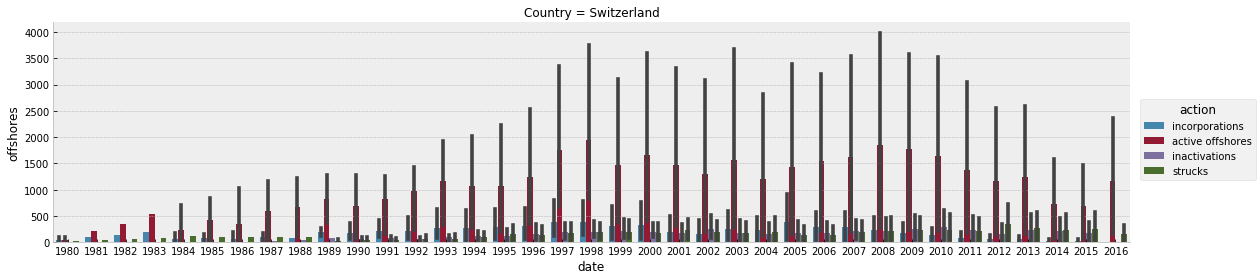

In [5]:
visualizer.visualize_countries_situation(countries_frame, divide_by='Country')

### Analysis on each Country over the jurisdictions
___

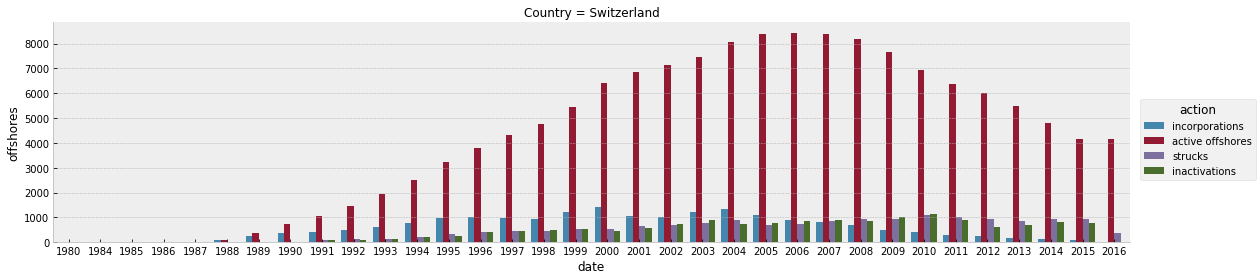

In [6]:
visualizer.visualize_countries_situation(countries_frame, divide_by='Country',selected_jurisdiction='British Virgin Islands')

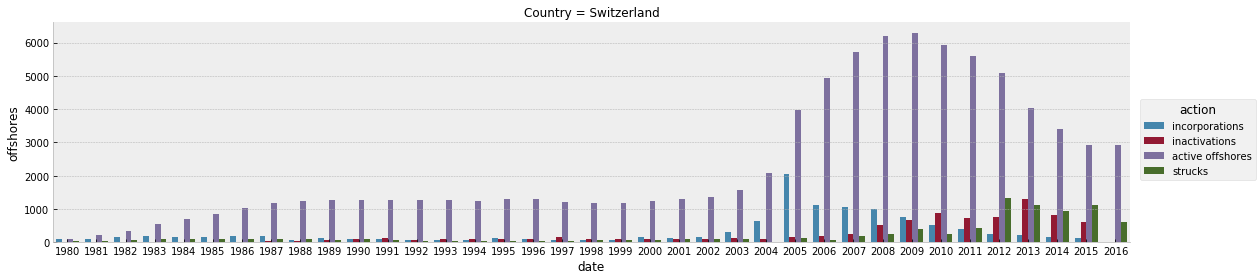

In [7]:
visualizer.visualize_countries_situation(countries_frame, divide_by='Country',selected_jurisdiction='Panama')

### How much money do you need in order to make an offshore account worthwhile?

Just because offshore accounts can be lucrative for the rich doesn’t mean they would be beneficial to everyone. The majority of Canadians don’t even reach the maximum contribution levels for their Tax Free Savings Accounts. 

> You really have to have accumulated capital that you’re investing, so you’re earning investment income. Most middle-income people don’t have investment income.

Even a physician or lawyer making upwards of \$250,000 probably still isn’t earning enough for an offshore account to be worthwhile, he says, especially after accounting for the legal and accounting costs in Canada, plus paying the foreign jurisdictions to set up the account.

> It’s worth it if you’ve accumulated family wealth—in the \$5 million-plus range and you’re earning five per cent or more per year.

Which is exactly why he says people have the right to be angry about such offshore accounts. 

> It’s a two-tiered system, but it’s not transparent. We don’t say ‘If you have $5 million a year, your tax rate is lower than everyone else’s’. That’d be completely unfair. People would be outraged. Yet here’s a non-transparent way for you to get the same result.

### Save csv

In [ ]:
features = ['actives offshores', 'incorporations', 'inactivations']
for feature in features:
    frame = preprocessing.process_countries_with_code(entities, 
                                                            all_countries, 
                                                            analisys_on='Country', 
                                                            from_year=1900, 
                                                            to_year=2017,
                                                            feature=feature
                                                           )
    name = feature
    if name == 'actives offshores':
        name = 'actives'
    frame.to_csv('csv/provacash_flows_'+name+'.csv', index=False)

Country done:Albania
Country done:American Samoa
Country done:Andorra
Country done:Andorra;Not identified
Country done:Angola
Country done:Anguilla
Country done:Antigua and Barbuda
Country done:Antigua and Barbuda;British Virgin Islands
Country done:Antigua and Barbuda;Not identified
Country done:Argentina
Country done:Aruba
Country done:Australia
Country done:Australia;Belize
Country done:Australia;British Virgin Islands
Country done:Australia;Not identified
Country done:Austria
Country done:Austria;British Virgin Islands
Country done:Austria;Not identified
Country done:Azerbaijan
Country done:Bahamas
Country done:Bahamas;Not identified
Country done:Bahamas;Panama
Country done:Bahrain
Country done:Bangladesh
Country done:Barbados
Country done:Belarus
Country done:Belarus;British Virgin Islands
Country done:Belarus;Not identified
Country done:Belgium
Country done:Belgium;British Virgin Islands
Country done:Belgium;Not identified
Country done:Belize
Country done:Belize;British Virgin Is